# Introduction

[here](https://www.kaggle.com/c/titanic/data?select=test.csv)

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import minmax_scale

from sklearn.feature_selection import RFECV
import joblib

pd.options.display.max_columns = 20
plt.style.use('fivethirtyeight')

In [83]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [84]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Loading Some Processing Functions

In [85]:
# %load ./data/functions.py
def process_scale(df, cols):
    for each in cols:
        df[each] = minmax_scale(df[each])
    return df

def process_missing(df):
    """
    Fills NA of 'Fare' with the mean of 'Fare'
    Fills NA of 'Embarked' with 'S'
    Returns `df`


    Usage
    ------

    process_df = process_missing(df)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """
    Process the Age column into pre-defined 'bins'
    [-1,0,5,12,18,35,60,100]
    ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    Fills NA with -0.5
    Returns `df`
    

    Usage
    ------

    process_df = process_age(df)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins'
    [-1,12,50,100,1000]
    ["0-12","12-50","50-100","100+"]
    Returns `df`


    Usage
    ------

    process_df = process_fare(df)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Creates 'Cabin_type' column
    Fills NA with 'Unknown'
    Creates 'Cabin_type' column with the cabin letter of 'Cabin' column
    Returns `df`


    Usage
    ------

    process_df = process_cabin(df)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 
    Creates 'Title' column using a dictionary of titles to simplify
    and categorize the status of each passenger


    Usage
    ------

    process_df = process_titles(df)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column


    Usage
    ------

    df_with_dummycols = create_dummies(df, column_name)
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, ['Age_categories','Fare_categories','Title','Cabin_type','Sex'])
    return df


In [86]:
train = process(train)
holdout = process(test)

# Investigating `SibSp` and `Parch`

I am going to investigate the family members each passenger had onboard: `SibSp` and `Parch`. I will use the mean survival rate as my baseline survival metric to score the features on importance.

In [87]:
survival_baseline = train['Survived'].mean()

In [88]:
focus_cols = ['SibSp', 'Parch']
target = 'Survived'
focus = train[focus_cols].copy()
focus_target = train[[target]].copy()
focus['family'] = focus['SibSp'] + focus['Parch']

focus_agg = pd.concat([focus, focus_target], axis=1)

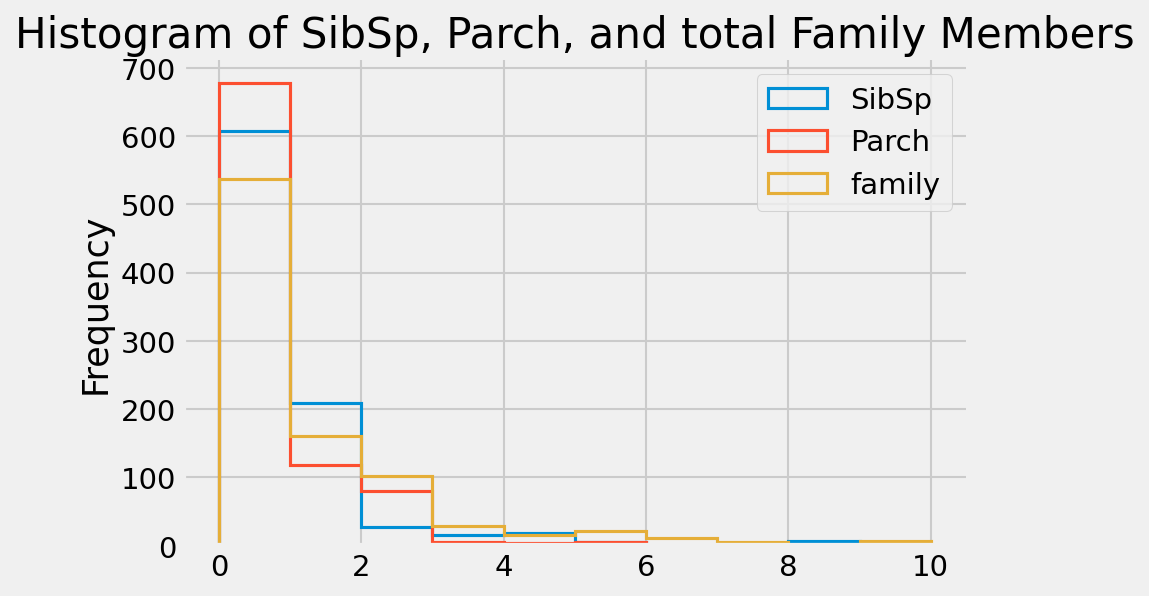

In [89]:
fig, ax = plt.subplots(dpi=150)
focus.plot.hist(histtype='step', ax=ax, linewidth=1.5) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Histogram of SibSp, Parch, and total Family Members')
plt.show()

Many passengers had no family, slightly more passengers had no parents or children than passengers with no siblings or spouses on the boat.

In [90]:
def survival_rate_plot(df, col):
    
    survival_rate = pd.pivot_table(df, 
                                   index = col, 
                                   values='Survived')
    
    fig, ax = plt.subplots(dpi=100)
    survival_rate.plot.bar(ax=ax, color='g')
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.hlines(y=survival_baseline, xmin=-1, xmax=10, 
               alpha = 0.5, color ='red', linestyles='dashdot')
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor tickys are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True) # labels along the bottom edge
    plt.title('Survival rate against \''+col +'\'')

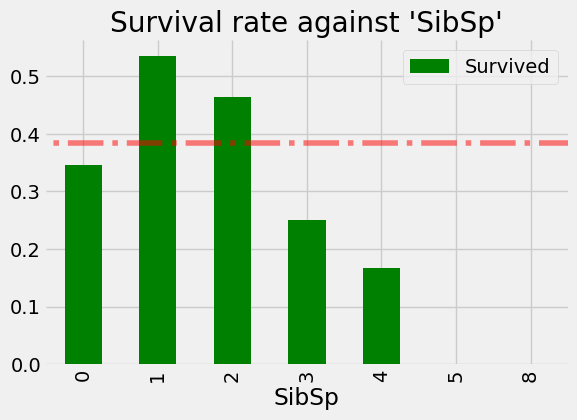

In [91]:
survival_rate_plot(focus_agg, 'SibSp')

Passengers with 1 or 2 siblings/spouses had a higher chance of survival. This makes sense, if a passenger had at least one spouse/sibling then they were more likely to help each other survive, and bigger groups of passengers took more organization and space to get to safety. However, there may be a bias that more couples were on the ship as more siblings did not equate to higher survival, and it was uncommon to have more than one spouse or a bias from having more people to survive 

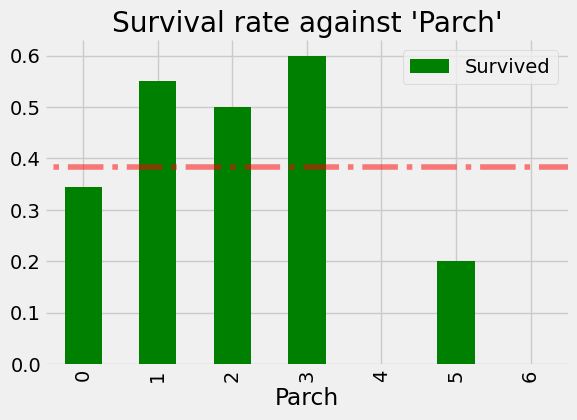

In [92]:
survival_rate_plot(focus_agg, 'Parch')

A similar pattern to the `SibSp` graph can be deduced from this graph. A parent is more likely to want to save themselves and their own children over other passengers. Life boat priority was also known to be given to mothers and children which means that having 2 parents or 1 to 3 children would increase a passenger's chance of surviving.

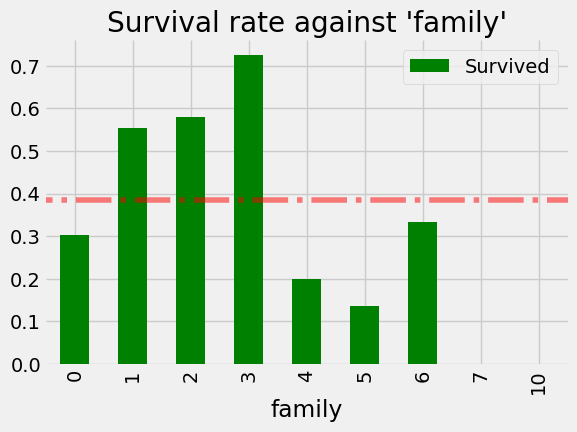

In [93]:
survival_rate_plot(focus_agg, 'family')

I will now create dummy columns for family, since there seems to be a decent survival rate for passengers with family onboard

In [94]:
train['family'] = train['SibSp'] + train['Parch']
train = create_dummies(train, 'family')
holdout['family'] = holdout['SibSp'] + holdout['Parch']
holdout = create_dummies(holdout, 'family')

# Feature Selection

In [97]:
def select_features(df):
    focus = df.select_dtypes(include='number').dropna()
    drop_cols = pd.Index(['Survived', 'PassengerId'])
    drop_cols = drop_cols[drop_cols.isin(focus.columns)]
    all_X = focus[focus.columns.drop(drop_cols)]
    all_y = focus['Survived']

    rfc = RandomForestClassifier(random_state=1)
    rfecv = RFECV(rfc, cv=10, n_jobs=-2)
    rfecv.fit(all_X, all_y)

    print('Selected Features: {}'.format(all_X.columns[rfecv.support_]))
    return all_X.columns[rfecv.support_]

In [98]:
features = select_features(train)

Selected Features: Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_B',
       'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male', 'family', 'family_0', 'family_1', 'family_2',
       'family_5'],
      dtype='object')


# Model Selection

I will compare accuracies between different types of models: KNeighbors, RandomForestRegressor, LogisticRegressor.

In [101]:
def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']

    models = [{
        'name': 'LogisticRegression',
        'estimator': LogisticRegression(),
        'param_grid': {
            "solver": ["newton-cg", "lbfgs", "liblinear"]
            }
        },
        {
        'name': 'KNeighborsClassifier',
        'estimator': KNeighborsClassifier(),
        'param_grid': {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
            }
        },
        {
            'name': 'RandomForestClassifier',
            'estimator': RandomForestClassifier(),
            'param_grid': {
                'n_estimators': [4, 6, 9],
                'criterion': ['entropy', 'gini'],
                'max_depth': [2, 5, 10],
                'max_features': ['log2', 'sqrt'],
                'min_samples_leaf': [1, 5, 8],
                'min_samples_split': [2, 3, 5]
            }
        }
    ]

    best_models = []
    for each in models:
        gs = GridSearchCV(each['estimator'], param_grid=each['param_grid'], cv=10, n_jobs=-2)
        gs.fit(all_X, all_y)
        best_models.append([gs.best_estimator_, gs.best_score_, gs.best_params_])

    return best_models


In [102]:
models = select_model(train, features)

c:\Users\Waylo\.virtualenvs\JNMachineLearning\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [103]:
models = pd.DataFrame(models, 
    index=['LogisticRegression', 'KNeighborsClassifier', 'RandomForestClassifier'], 
    columns=['Estimator', 'Score', 'Hyperparameters'])

In [104]:
def save_submission_file(model, features, filename='submission.csv'):
    predictions = model.predict(holdout[features])
    
    #create dataframe
    submission_df = {'PassengerId': holdout['PassengerId'],
                     'Survived': predictions}
    submission = pd.DataFrame(submission_df)

    #create .csv file
    submission.to_csv(f'{filename}.csv', index=False)
    
    print(f'Created {filename}.csv!')
    return submission

In [106]:
print(models.iloc[models['Score'].argmax()])

Estimator          (DecisionTreeClassifier(max_depth=10, max_feat...
Score                                                       0.835056
Hyperparameters    {'criterion': 'gini', 'max_depth': 10, 'max_fe...
Name: RandomForestClassifier, dtype: object


In [107]:
process_scale(train, features)
models = select_model(train, features)
models = pd.DataFrame(models, 
    index=['LogisticRegression', 'KNeighborsClassifier', 'RandomForestClassifier'], 
    columns=['Estimator', 'Score', 'Hyperparameters'])

print(models.iloc[models['Score'].argmax()])

Estimator          (DecisionTreeClassifier(criterion='entropy', m...
Score                                                       0.836192
Hyperparameters    {'criterion': 'entropy', 'max_depth': 10, 'max...
Name: RandomForestClassifier, dtype: object
